<a href="https://colab.research.google.com/github/akalpit23/Adversarial-Patch/blob/main/Adversarial_Patch_Assignment_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #02

### Akalpit Dawkhar


In [ ]:
# !pip install torch torchvision adversarial-robustness-toolbox opencv-python numpy scipy tqdm matplotlib seaborn

In [ ]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Adversarial-Patch" # Change to your repo name
git_path = 'https://github.com/akalpit23/Adversarial-Patch.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'Adversarial_Patch_Assignment_02.ipynb'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

In [ ]:
## Standard libraries
import os
import cv2
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

In [ ]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

In [ ]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

In [ ]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

In [ ]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

## Patch Placement on an Image

In [ ]:
def place_single_large_patch(img, patch):
    """
    Places a single large patch randomly on an image.

    This function iterates over each image in a batch and places a single patch
    randomly on each image by selecting random horizontal and vertical offsets.
    The patch is inserted by calling the `patch_forward` function.

    Args:
        img (numpy.ndarray): A batch of images with shape (batch_size, channels, height, width).
                             Each image will have the patch applied.
        patch (numpy.ndarray): A patch to be placed on the image with shape (channels, patch_height, patch_width).
                               This patch is applied to the image at a random location.

    Returns:
        numpy.ndarray: The batch of images with the patch placed on each image.

    Raises:
        ValueError: If the patch size is larger than the corresponding dimensions of the image.

    Notes:
        - The `patch_forward` function is assumed to apply some transformation to the patch
          before it is placed on the image.
        - This function operates in place, modifying the input `img` array directly.
    """

    for i in range(img.shape[0]):
        h_offset = np.random.randint(0, img.shape[2] - patch.shape[1] - 1)
        w_offset = np.random.randint(0, img.shape[3] - patch.shape[2] - 1)
        img[i, :, h_offset:h_offset + patch.shape[1], w_offset:w_offset + patch.shape[2]] = patch_forward(patch)
    return img


In [ ]:
def place_multiple_small_patches(img, patch, num_patches=3):
 """
    Places multiple small patches randomly on each image in a batch.

    This function iterates over each image in a batch and places multiple small patches
    randomly on each image by selecting random horizontal and vertical offsets.
    The number of patches to place on each image is controlled by the `num_patches` argument.

    Args:
        img (numpy.ndarray): A batch of images with shape (batch_size, channels, height, width).
                             Each image will have multiple patches applied.
        patch (numpy.ndarray): A small patch to be placed on the image with shape (channels, patch_height, patch_width).
                               This patch is applied to the image at random locations.
        num_patches (int, optional): The number of patches to place on each image. Defaults to 3.

    Returns:
        numpy.ndarray: The batch of images with multiple patches placed on each image.

    Raises:
        ValueError: If the patch size is larger than the corresponding dimensions of the image.

    Notes:
        - The `patch_forward` function is assumed to apply some transformation to the patch
          before it is placed on the image.
        - This function operates in place, modifying the input `img` array directly.
    """
    for i in range(img.shape[0]):
        for _ in range(num_patches):  # Place multiple patches
            h_offset = np.random.randint(0, img.shape[2] - patch.shape[1] - 1)
            w_offset = np.random.randint(0, img.shape[3] - patch.shape[2] - 1)
            img[i, :, h_offset:h_offset + patch.shape[1], w_offset:w_offset + patch.shape[2]] = patch_forward(patch)
    return img


In [ ]:
def eval_patch(model, patch, val_loader, target_class):
  """
    Evaluates the effectiveness of a patch on a model by measuring targeted attack success.

    This function applies multiple small patches to images from a validation dataset,
    then passes the patched images through the model to determine how often the model
    misclassifies the image as the `target_class`. It calculates both top-1 and top-5 attack success rates.

    Args:
        model (torch.nn.Module): The model to be evaluated. It should be in evaluation mode during this function.
        patch (torch.Tensor): The adversarial patch to be applied, with shape (channels, patch_height, patch_width).
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset. Provides batches of images and labels.
        target_class (int): The target class that the patch aims to misclassify images into.

    Returns:
        float: The top-1 accuracy of the targeted attack, i.e., the fraction of images misclassified as the target class.
        float: The top-5 accuracy of the targeted attack, i.e., the fraction of images where the target class is in the top 5 predictions.

    Notes:
        - The function only considers images that are **not** originally labeled as `target_class`.
          It checks how often the model misclassifies those images into the target class.
        - The `place_multiple_small_patches` function is used to apply multiple patches to each image.
        - The function assumes that `patch_img` and `img_labels` are transferred to the appropriate device (e.g., GPU).
        - The evaluation loop runs 4 times for each batch of images to apply the patch and check the predictions.

    Raises:
        None: This function assumes proper input formatting and device configuration.
    """
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            for _ in range(4):
                patch_img = place_multiple_small_patches(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

## Creating an attack in which multiple patches are placed

In [ ]:
def patch_attack_multiple(model, target_class, patch_size=64, num_patches=3, num_epochs=5):
    # Split the dataset into train and validation sets
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create patch parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_multiple_small_patches(img, patch, num_patches=num_patches)  # Apply multiple small patches
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}


## Creating an attack in which only a single patch is placed

In [ ]:
def patch_attack_single(model, target_class, patch_size=64, num_epochs=5):
     """
    Performs an adversarial attack using a single large patch on a model to force misclassification into a target class.

    This function applies a large patch to images in a dataset, and updates the patch over multiple epochs to maximize
    the likelihood that the model classifies the images into the specified `target_class`. The attack is performed
    using stochastic gradient descent (SGD) to optimize the patch based on cross-entropy loss with the target class.

    Args:
        model (torch.nn.Module): The model to be attacked. It should be compatible with the dataset.
        target_class (int): The target class that the adversarial patch aims to misclassify the images into.
        patch_size (int, optional): The size of the patch to be applied (patch is square). Default is 64.
        num_epochs (int, optional): The number of training epochs for optimizing the patch. Default is 5.

    Returns:
        torch.Tensor: The optimized adversarial patch.
        dict: A dictionary containing:
            - 'acc': The top-1 accuracy of the targeted attack (fraction of misclassified images).
            - 'top5': The top-5 accuracy of the targeted attack (fraction of images where the target class is in the top 5 predictions).

    Notes:
        - The function splits the dataset into training and validation sets, and uses DataLoader for batch processing.
        - The `patch` is initialized as a parameter and optimized using stochastic gradient descent (SGD).
        - The `place_single_large_patch` function is used to apply the patch to images during training.
        - The `eval_patch` function is used to evaluate the patch performance on a validation set after training.
        - This function assumes that the dataset and model are configured to run on the appropriate device (e.g., GPU).

    Raises:
        None: This function assumes proper input formatting, device configuration, and compatibility of the model with the dataset.
    """
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create patch parameter and optimizer
    patch = nn.Parameter(torch.zeros(3, patch_size, patch_size), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_single_large_patch(img, patch)  # Apply the large patch
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}


In [ ]:
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)


def save_results(patch_dict):
   """
    Saves the results of adversarial patch evaluations to a JSON file.

    This function processes the results stored in `patch_dict`, ensuring that any
    PyTorch tensors are converted to standard Python types (such as floats) before saving.
    The results are then written to a JSON file for later use.

    Args:
        patch_dict (dict): A dictionary containing patches and their evaluation results.

    Returns:
        None: The function saves the results to a JSON file and does not return any values.

    Notes:
        - The results are saved in a file named `patch_results.json` located in the `CHECKPOINT_PATH` directory.
        - Tensors in the results are converted to Python types before saving to ensure compatibility with JSON.
        - The function assumes that `CHECKPOINT_PATH` is a globally accessible variable.
    """
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

In [ ]:
def get_patches(class_names, patch_sizes):
   """
    Retrieves or trains adversarial patches for specified classes and patch sizes, and stores the results.

    This function loops over a set of class names and patch sizes, either loading pre-trained patches from file
    or training new patches using the `patch_attack_multiple` function. After the patches are obtained, they are
    evaluated using the `eval_patch` function, and the patches along with the evaluation results are stored in a
    dictionary for further use.

    Args:
        class_names (list of str): A list of class names for which adversarial patches should be generated or loaded.
        patch_sizes (list of int): A list of patch sizes to be used when generating or loading patches.

    Returns:
        dict: A dictionary containing patches and evaluation results for each class name and patch size.


    Notes:
        - If a pre-trained patch file (in the format `"{name}_{patch_size}_patch.pt"`) does not exist, the function
          will train a new patch using the `patch_attack_multiple` function, save it to disk, and print validation results.
        - If evaluation results are not already loaded from `json_results`, the function will manually evaluate the patch
          using the `eval_patch` function.
        - The trained or loaded patch and the evaluation results are saved in the `result_dict` for easy access.

    Raises:
        None: This function assumes that file paths, model checkpoints, and data loaders are properly set up.

    Dependencies:
        - The function depends on variables like `CHECKPOINT_PATH`, `pretrained_model`, `label_names`, `json_results`,
          and `data_loader` being globally accessible.
    """
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack_multiple(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

## Evaluating both the patches

In [ ]:
# Evaluate one large patch
patch_size_large = 64
large_patch, results_large = patch_attack_single(pretrained_model, target_class=get_label_index('manhole cover'), patch_size=patch_size_large, num_epochs=5)

# Evaluate multiple small patches
patch_size_small = 32
num_patches = 3  # Place the small patch multiple times
small_patch, results_small = patch_attack_multiple(pretrained_model, target_class=get_label_index('manhole cover'), patch_size=patch_size_small, num_patches=num_patches, num_epochs=5)


print(f"Results with one large patch: {results_large}")
print(f"Results with multiple small patches: {results_small}")

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Results with one large patch: {'acc': 0.9924699068069458, 'top5': 0.9994980096817017}
Results with multiple small patches: {'acc': 0.6357715725898743, 'top5': 0.8732464909553528}


## Printing out the patches

In [ ]:
class_names = ['manhole cover', 'necklace','pineapple']
patch_sizes = [64,32]

patch_dict = get_patches(class_names, patch_sizes)
save_results(patch_dict) # Uncomment if you add new class names and want to save the new results

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for manhole cover and 64: {'acc': 0.9934870004653931, 'top5': 0.9994990229606628}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for manhole cover and 32: {'acc': 0.6678356528282166, 'top5': 0.8852705359458923}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for necklace and 64: {'acc': 0.9980000257492065, 'top5': 0.9994999766349792}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for necklace and 32: {'acc': 0.9484999775886536, 'top5': 0.9879999756813049}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for pineapple and 64: {'acc': 0.9980000257492065, 'top5': 1.0}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for pineapple and 32: {'acc': 0.975450873374939, 'top5': 0.9944889545440674}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

## Visualizing the generated patches

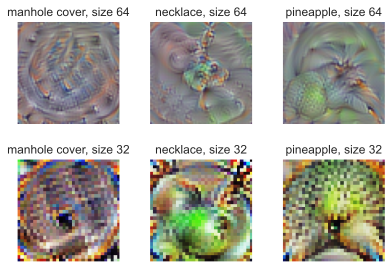

In [ ]:
def show_patches():
  """
    Displays a grid of adversarial patches for different class names and patch sizes.

    This function visualizes adversarial patches from the `patch_dict` by converting the patch tensors into
    pixel values and displaying them using Matplotlib. Each patch is displayed in a grid where the rows
    represent different patch sizes and the columns represent different class names.

    Args:
        None: The function assumes that `patch_sizes`, `class_names`, and `patch_dict` are globally accessible variables.

    Returns:
        None: The function generates a Matplotlib plot showing the patches and does not return any values.

    Notes:
        - Patches are converted from parameter values to pixel values using the transformation `(torch.tanh(patch) + 1) / 2`.
        - The function assumes that each entry in `patch_dict` contains a "patch" key with a PyTorch tensor representing the patch.
        - The grid is dynamically sized based on the number of class names and patch sizes.
    """
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
show_patches()

## Showing the orginal predection

In [ ]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):
  """
    Displays an image, its true label, and the model's top-K predictions, optionally including adversarial images and noise.

    This function visualizes the input image along with its true label and the model's top-K predictions in a bar plot,
    showing the confidence values. If adversarial images and noise are provided, they are also displayed.

    Args:
        img (torch.Tensor or numpy.ndarray): The input image to be displayed. If it's a PyTorch tensor, it's converted to a numpy array.
        label (int or torch.Tensor): The true label of the image. If it's a tensor, it's converted to an integer.
        pred (torch.Tensor): The model's prediction probabilities. If the sum of the predictions is not 1, softmax is applied.
        K (int, optional): The number of top predictions to display in the bar plot. Default is 5.
        adv_img (torch.Tensor or numpy.ndarray, optional): The adversarial image to be displayed, if provided.
        noise (torch.Tensor or numpy.ndarray, optional): The noise added to create the adversarial image, if provided.

    Returns:
        None: The function generates a Matplotlib plot and does not return any values.

    Notes:
        - If `img`, `adv_img`, or `noise` are PyTorch tensors, they are converted to numpy arrays for display.
        - The image is normalized based on `NORM_MEAN` and `NORM_STD`, and values are clipped to the range [0, 1].
        - If adversarial images and noise are provided, the function will display them in a side-by-side layout along with the original image.
        - The top-K predictions are shown as a horizontal bar plot with the confidence values.
        - If any of the top-K predictions matches the true label, it is highlighted in a different color.
    """

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

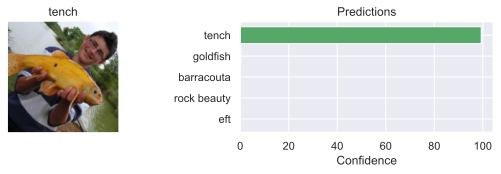

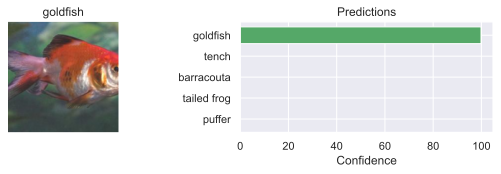

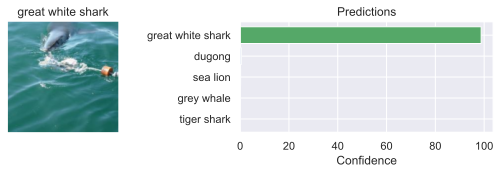

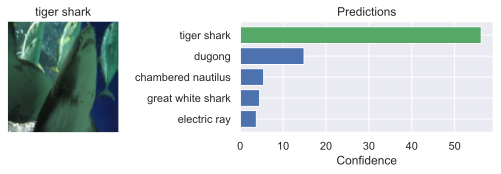

In [ ]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

## Creating an attack that includes placing multiple small as well just a single patch on an image

In [ ]:
def perform_patch_attack_multiple(patch):
  """
    Performs an adversarial patch attack using multiple small patches on a batch of images.

    This function applies multiple small patches to a cloned batch of example images,
    feeds the patched images through the model, and visualizes the results by displaying
    predictions for a subset of the images.

    Args:
        patch (torch.Tensor): The adversarial patch to be applied to the batch of images.

    Returns:
        None: The function visualizes the patched images and model predictions, but does not return any values.

    Notes:
        - The function uses `place_multiple_small_patches` to apply the patch to each image in the batch.
        - The predictions are displayed for a subset of the batch (indices 1, 6, 11, and 16).
        - The function assumes that `exmp_batch`, `label_batch`, and `pretrained_model` are globally accessible.
    """
    patch_batch = exmp_batch.clone()
    patch_batch = place_multiple_small_patches(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])


def perform_patch_attack_single(patch):
  """
    Performs an adversarial patch attack using a single large patch on a batch of images.

    This function applies a single large patch to a cloned batch of example images,
    feeds the patched images through the model, and visualizes the results by displaying
    predictions for a subset of the images.

    Args:
        patch (torch.Tensor): The adversarial patch to be applied to the batch of images.

    Returns:
        None: The function visualizes the patched images and model predictions, but does not return any values.

    Notes:
        - The function uses `place_single_large_patch` to apply the patch to each image in the batch.
        - The predictions are displayed for a subset of the batch (indices 1, 6, 11, and 16).
        - The function assumes that `exmp_batch`, `label_batch`, and `pretrained_model` are globally accessible.
    """
    patch_batch = exmp_batch.clone()
    patch_batch = place_single_large_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

## Attacking an image with multiple small patches

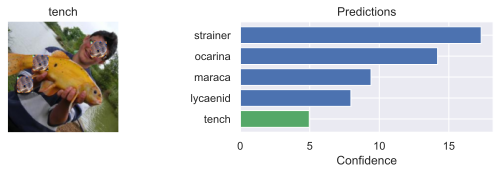

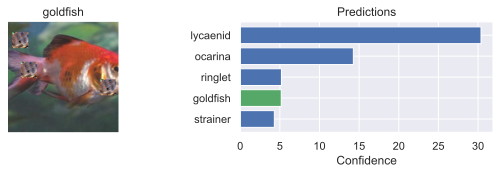

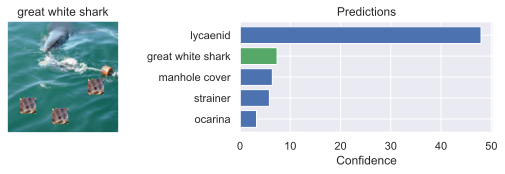

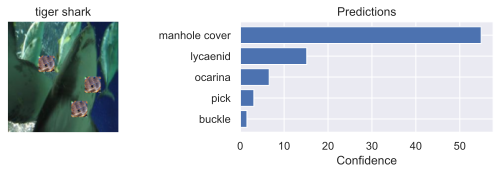

In [ ]:
perform_patch_attack_multiple(patch_dict['necklace'][32]['patch'])

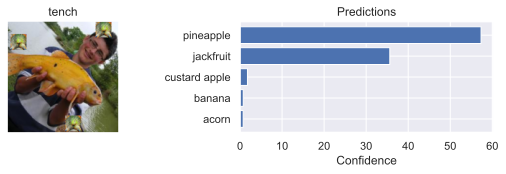

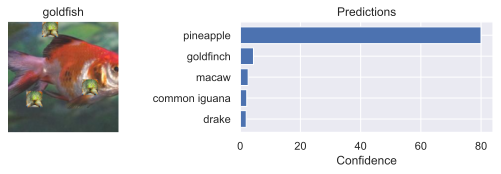

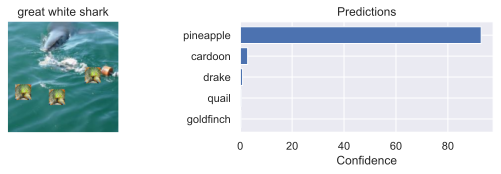

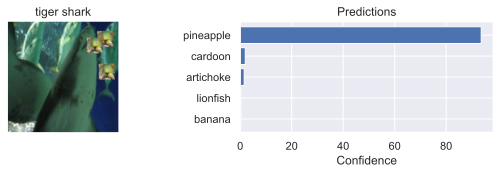

In [ ]:
perform_patch_attack_multiple(patch_dict['pineapple'][32]['patch'])

## Attacking an image with a Large single patch

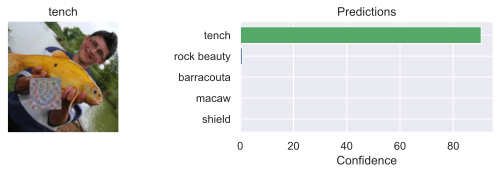

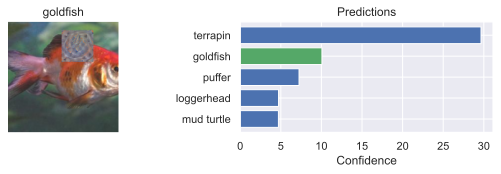

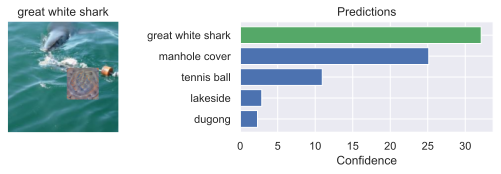

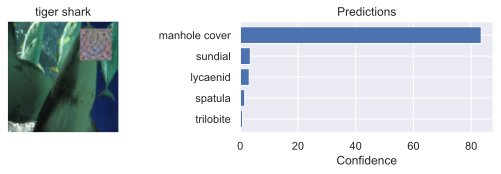

In [ ]:
perform_patch_attack_single(patch_dict['manhole cover'][64]['patch'])

# Reference:


1.   https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb#scrollTo=EvWZTPmL1sGP
2.   Perplexity AI

